In [1]:
import basis_set_exchange as bse
import scipy as sp
import matplotlib.pyplot as plt
from pyscf import gto,scf
import copy
import numpy as np
import scipy
from scipy.interpolate import interp1d
from pyscf.data.elements import _symbol
from numpy.linalg import norm

In [2]:
import sys
sys.path.append("./Libs")
from FcMole import FcM
from FDcoeffs import get_coeffs

In [13]:
#5pts finite difference coefficients
fd1=np.asarray([1/12,-2/3 ,0,2/3,-1/12])
fd2=np.asarray([-1/12,4/3,-5/2,4/3,-1/12])
fd3=np.asarray([-1/2,1,0,-1,1/2])
fd4=np.asarray([1,-4,6,-4,1])
fds=[fd1,fd2,fd3,fd4]
fds5=get_coeffs(5)
fds7=get_coeffs(7)

In [3]:
def sto(z,ref=None):
    if z <1.e-10: raise Exception("non implemented Zero charge atom")
    if z%1 <1.e-10:
        return gto.basis.load(bse.get_basis("sto-3G",fmt="nwchem",elements=[int(z)]),_symbol(int(z)))
    elif ref:
        rb=sto(ref)
        rbm=sto(ref-1)
        rbp=sto(ref+1)
        fb=copy.deepcopy(rb)
        for i in range(len(fb)):
            for j in range(1,len(fb[i])):  # ref+a(z-zr) +b(z-zr)^2
                a=(rbp[i][j][0]-rbm[i][j][0])/2
                b=(rbp[i][j][0]+rbm[i][j][0]-2*rb[i][j][0])
                fb[i][j][0]+=a*(z-ref)+b*(z-ref)**2/2
        return fb
    else: raise Exception("can't get the fractional charge basis set, frac val and no ref")

In [165]:
def pcX(z,ref=None):
    if z <1.e-10: raise Exception("non implemented Zero charge atom")
    if z%1 <1.e-10:
        return gto.basis.load(bse.get_basis("pcX-1",fmt="nwchem",elements=[int(z)]),_symbol(int(z)))
    elif ref:
        rb=pcX(ref)
        rbm=pcX(ref-1)
        rbp=pcX(ref+1)
        fb=copy.deepcopy(rb)
        for i in range(len(fb)):  # ref+a(z-zr) +b(z-zr)^2
            a=(rbp[i][1][0]-rbm[i][1][0])/2
            b=(rbp[i][1][0]+rbm[i][1][0]-2*rb[i][1][0])
            fb[i][1][0]+=a*(z-ref)+b*(z-ref)**2/2
        return fb
    else: raise Exception("can't get the fractional charge basis set, frac val and no ref")

In [306]:
def pcX_tbo(z,c1=1,c2=2,ref=None):
    #c1=1
    #c2=1.9755
    if z <1.e-10: raise Exception("non implemented Zero charge atom")
    if z%1 <1.e-10:
        return gto.basis.load(bse.get_basis("pcX-1",fmt="nwchem",elements=[int(z)]),_symbol(int(z)))
    elif ref:
        rb=pcX(ref)
        rbm=pcX(ref-1)
        rbp=pcX(ref+1)
        fb=copy.deepcopy(rb)
        for i in range(len(fb)):  # ref+a(z-zr) +b(z-zr)^2
            a=(rbp[i][1][0]-rbm[i][1][0])/2
            b=(rbp[i][1][0]+rbm[i][1][0]-2*rb[i][1][0])/2
            fb[i][1][0]+=a*np.sign(z-ref)*abs(z-ref)**c1+b*abs(z-ref)**c2
            #fb[i][1][0]+=a*(z-ref)+b*(z-ref)**2/2
        return fb
    else: raise Exception("can't get the fractional charge basis set, frac val and no ref")

In [302]:
def E_nc(l,c1=.918,c2=1.9 ):
    mol_l=gto.M(atom="N1 0 0 0",unit="Bohrs",basis={"N1":pcX_tbo(7-l,c1,c2,ref=7)},verbose=1,spin=3)  
    mf_l=scf.RHF(mol_l)
    mf_l.conv_tol=1e-12
    mf_l.conv_tol_grad=1e-12
    e=mf_l.scf(dm0=mf_l.init_guess_by_1e())
    return e

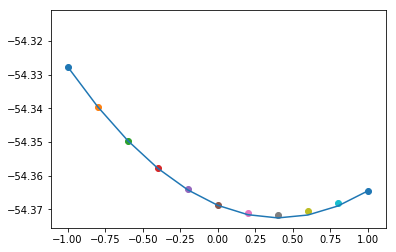

In [303]:
ls=np.linspace(-1,1,11)
for i in ls:
    plt.scatter(i,E_nc(i))
a=(E_nc(1)-E_nc(-1))/2
b=(E_nc(1)+E_nc(-1)-2*E_nc(0))
plt.plot(ls,E_nc(0)+a*(ls)+b*(ls)**2/2)

In [293]:
e_n=E_nc(0,1,2)
def fun(x):
    c1,c2=x[0],1.9
    return abs(E_nc(.5,c1,c2)-e_n-a*(.5)-b*(.5)**2/2)+abs(E_nc(-.5,c1,c2)-e_n-a*(-.5)-b*(.5)**2/2)+\
            +abs(E_nc(-.2,c1,c2)-e_n-a*(-.2)-b*(.2)**2/2)+abs(E_nc(.2,c1,c2)-e_n-a*(.2)-b*(.2)**2/2)

In [294]:
fun([1])

0.0033120181052943565

In [301]:
fun([.918 ]),fun([.92 ]),fun([.922 ])

(0.0017060540236475668, 0.0017160550174939709, 0.0017261126010741628)

In [109]:
mf_co=scf.RHF(gto.M(atom="C 0 0 0; O 0 0 2.05",unit="Bohrs",basis=bse.get_basis("pcX-1"\
                                                       ,fmt="nwchem",elements=["C","N","O"])))
e_co=mf_co.scf()
p_co=mf_co.make_rdm1()
mf_nn=scf.RHF(gto.M(atom="N 0 0 0; N 0 0 2.05",unit="Bohrs",basis=bse.get_basis("pcX-1"\
                                                       ,fmt="nwchem",elements=["C","N","O"])))
e_nn=mf_nn.scf()
p_nn=mf_nn.make_rdm1()

converged SCF energy = -112.716141826715
converged SCF energy = -108.916591616523


In [265]:
def E(l,zbs=True):
    if zbs:
        mol_l=FcM(fcs=[-l,l],atom="N1 0 0 0; N2 0 0 2.05",unit="Bohrs",basis={"N1":pcX_tbo(7-l,ref=7),"N2":pcX_tbo(7+l,ref=7)},verbose=1)
    else:
         mol_l=FcM(fcs=[-l,l],atom="N1 0 0 0; N2 0 0 2.05",unit="Bohrs",basis={"N1":pcX(7,ref=7),"N2":pcX(7,ref=7)},verbose=1)       
    mf_l=scf.RHF(mol_l)
    #mf_l.conv_tol=1e-12
    #mf_l.conv_tol_grad=1e-12
    e=mf_l.scf(dm0=p_nn)
    return e

In [307]:
dl=.1
Es=np.asarray([E(-3*dl),E(-2*dl),E(-dl),e_nn,E(dl),E(2*dl),E(3*dl)])
apdft=[e_nn]
inc=[]
for i in range(6):
    inc.append(np.einsum('i,i',fds7[i+1],Es)/dl**(i+1)/np.math.factorial(i+1))
    apdft.append(apdft[i]+inc[-1] )
apdft,e_co

([-108.91659161652328,
  -108.91659161652234,
  -112.73562595297656,
  -112.7356259530189,
  -112.6921086226752,
  -112.69210862232586,
  -112.74427294309004],
 -112.71614182671495)

In [259]:
apdft=[e_nn]
inc=[]
for i in range(6):
    inc.append(np.einsum('i,i',fds7[i+1],Es)/dl**(i+1)/np.math.factorial(i+1))
    apdft.append(apdft[i]+inc[-1] )
apdft,e_co

([-108.91659161652328,
  -108.91659161652346,
  -112.74897154578501,
  -112.74897154578235,
  -112.49915371456818,
  -112.4991537145741,
  -113.74205620975029],
 -112.71614182671495)

In [308]:
apdft=[e_nn]
inc=[]
for i in range(6):
    inc.append(np.einsum('i,i',fds7[i+1],Es_nb)/dl**(i+1)/np.math.factorial(i+1))
    apdft.append(apdft[i]+inc[-1] )
apdft,e_co

([-108.91659161652328,
  -108.91659161652323,
  -112.67476193932389,
  -112.67476193932596,
  -112.66823228260249,
  -112.66823228260841,
  -112.66815462295193],
 -112.71614182671495)

In [139]:
dl=.1
Es=np.asarray([E(-3*dl),E(-2*dl),E(-dl),e_nn,E(dl),E(2*dl),E(3*dl)])
Es_nc=np.asarray([E_nc(-3*dl),E_nc(-2*dl),E_nc(-dl),e_nn,E_nc(dl),E_nc(2*dl),E_nc(3*dl)])
#Es-=Es_nc
apdft=[e_nn]
inc=[]
for i in range(6):
    inc.append(np.einsum('i,i',fds7[i+1],Es_nc)/dl**(i+1)/np.math.factorial(i+1))
    apdft.append(apdft[i]+inc[-1] )
apdft,E_nc(1),e_co

([-108.91659161652328,
  -108.91659161652119,
  -108.90670184736065,
  -108.90670184744059,
  -108.86130094703698,
  -108.86130094645671,
  -108.92434908561063],
 -108.89005609416202,
 -112.71614182671495)

In [116]:
e_nn
(apdft+E_nc(1)-e_nn)[-1] -9.17807153e-03,(apdft+E_nc(1)-e_nn)[-1] -9.17807153e-03+3.32489272e-03

(-74.18226647198351, -74.17894157926371)

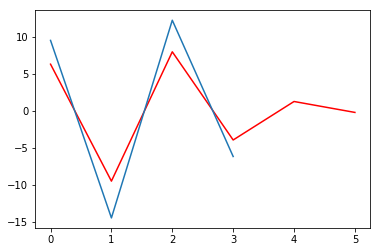

In [120]:
ple=[]
ple2=[]
ls=np.linspace(0,.8,10)
po=8
for i in ls:
    ple.append(E_nc(i))
    ple2.append(E(i))
plt.plot(scipy.polyfit(ls,ple,po)[1:-2],color="red")
plt.plot(scipy.polyfit(ls,ple2,po)[1:-4])

The parabolic coefficients are good enough .